In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

%matplotlib inline

Download dataset. Dataset consists of character randred in different fonts as 28x28 image. 

In [2]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
    """A hook to report the progress of a download. This is mostly intended for users with
    slow internet connections. Reports every 1% change in download progress.
    """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)
    
    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()
    
    last_percent_reported = percent


def maybe_download(filename, expected_bytes, force = False):
    """Download a file if not present, and make sure it's the right size."""
    if force or not os.path.exists(filename):
        print ("Attempting to downoad file: ", filename)
        filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
        print('Download Complete!')
    statinfo = os.stat(filename)
    
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        raise Exception('Failed to verify ' + filename + '. Can you get to it with a browser?')
    
    return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz


Extract data. It would give the directory labeld from A to J.

In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]
    
    if os.path.isdir(root) and not force:
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall()
        tar.close()
    
    data_folders = [
        os.path.join(root, d) for d in sorted(os.listdir(root))
        if os.path.isdir(os.path.join(root, d))]
    
    if len(data_folders) != num_classes:
        raise Exception(
            'Expected %d folders, one per class. Found %d instead.' % (
                num_classes, len(data_folders)))
    
    print(data_folders)
    return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

notMNIST_large already present - Skipping extraction of notMNIST_large.tar.gz.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
notMNIST_small already present - Skipping extraction of notMNIST_small.tar.gz.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


-------------------------

### Problem 1
Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

In [4]:
def diplay_one_image_from_each_folder(folders):
    for folder in folders:
        image_files = os.listdir(folder)
        print("Letter: ",folder.split('/')[1])
        image_file = os.path.join(folder, image_files[10])
        display(Image(filename=image_file))

In [5]:
diplay_one_image_from_each_folder(train_folders)

Letter:  A


Letter:  B


Letter:  C


Letter:  D


Letter:  E


Letter:  F


Letter:  G


Letter:  H


Letter:  I


Letter:  J


-------------------------------------

In [20]:
image_size = 28 # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folders, min_num_images, max_images):
    """Load the data for a single letter label."""
    dataset = np.ndarray(shape=(max_images, image_size, image_size),
                         dtype=np.float32)
    labels = np.ndarray(shape=max_images, dtype=np.int32)
    num_images = 0
    label_index = 0
    for folder in folders:
        print(folder)
        for image in os.listdir(folder):
            if num_images >= max_images:
                raise ('More than expected images: %d >= %d.' % (num_images, max_images))
            image_file = os.path.join(folder, image)
            try:
                image_data = (ndimage.imread(image_file).astype(float) 
                              - pixel_depth / 2) / pixel_depth
                if image_data.shape != (image_size, image_size):
                    raise Exception('Unexpected image shape: %s' % str(image_data.shape))
                dataset[num_images, :, :] = image_data
                labels[num_images] = label_index
                num_images = num_images + 1
            except IOError as e:
                print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
        label_index += 1    
    
    dataset = dataset[0:num_images, :, :]
    labels = labels[0:num_images]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' 
                        % (num_images, min_num_images))
    
    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    print('Label:', labels.shape)
    return dataset, labels
        
train_dataset, train_labels = load_letter(train_folders, 450000, 550000)
test_dataset, test_labels = load_letter(test_folders, 18000, 20000)

Full dataset tensor: (18724, 28, 28)
Mean: -0.0746362
Standard deviation: 0.458622
Label: (18724,)


------------

### Problem 2
Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

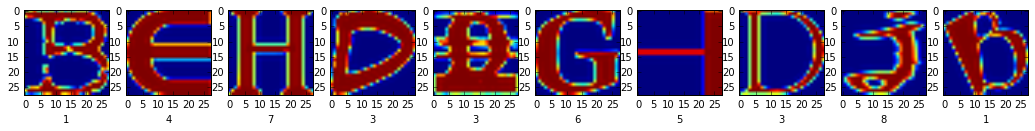

In [21]:
import random
fig = plt.figure(figsize=(18,5))
random.seed(121)
for i in range(1,11):
    fig.add_subplot(1, 10, i)
    
    index = random.randrange(529114)
    plt.imshow(train_dataset[index])
    plt.xlabel(train_labels[index])

-------------
### Problem 3
Another check: we expect the data to be balanced across classes. Verify that.


In [22]:
print ("Training data Frequency:", np.bincount(train_labels))
print ("Test data Frequency:",np.bincount(test_labels))

Training data Frequency: [52909 52911 52912 52911 52912 52912 52912 52912 52912 52911]
Test data Frequency: [1872 1873 1873 1873 1873 1872 1872 1872 1872 1872]


---------

Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [23]:
np.random.seed(133)
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)

- Split data into train and validtion.
- Create a validation dataset for hyperparameter tuning.

In [24]:
train_size = 200000
valid_size = 10000

valid_dataset = train_dataset[:valid_size,:,:]
valid_labels = train_labels[:valid_size]
train_dataset = train_dataset[valid_size:valid_size+train_size,:,:]
train_labels = train_labels[valid_size:valid_size+train_size]
print ('Training data shape (', train_dataset.shape, ',', train_labels.shape, ',')
print ('Validation data shape (', valid_dataset.shape, ',', valid_labels.shape, ',')

Training data shape ( (200000, 28, 28) , (200000,) ,
Validation data shape ( (10000, 28, 28) , (10000,) ,


------------
### Problem 4
Convince yourself that the data is still good after shuffling!

In [25]:
print ("Training data Frequency:", np.bincount(train_labels))
print ("Validation data Frequency:",np.bincount(valid_labels))
print ("Test data Frequency:", np.bincount(test_labels))

Training data Frequency: [20066 19720 20107 19904 20094 20044 20157 20036 19910 19962]
Validation data Frequency: [1033 1014 1008  985  956  962 1038  975 1034  995]
Test data Frequency: [1872 1873 1873 1873 1873 1872 1872 1872 1872 1872]


---------

Finally, let's save the data for later reuse:

In [26]:
pickle_file = 'notMNIST.pickle'

try:
    f = open(pickle_file, 'wb')
    save = {'train_dataset': train_dataset,
            'train_labels': train_labels,
            'valid_dataset': valid_dataset,
            'valid_labels': valid_labels,
            'test_dataset': test_dataset,
            'test_labels': test_labels,
           }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print ('Unable to save data to', pickle_file, ':', e)
    raise

In [27]:
## Load data from pickle
pickle_file = 'notMNIST.pickle'

try:
    files = pickle.load(open(pickle_file,'rb'))
except Exception as e:
    print('Could not find pickle file', pickle_file, ':', e)

In [28]:
statinfo = os.stat(pickle_file)
print ('Compressed pickle size:', statinfo.st_size)

train_dataset, train_labels = files['train_dataset'],files['train_labels']
valid_dataset, valid_labels = files['valid_dataset'], files['valid_labels']
test_dataset, test_labels = files['test_dataset'], files['test_labels']

Compressed pickle size: 718193881


---------
### Problem 5
By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it. Measure how much overlap there is between training, validation and test samples.
Optional questions:
What about near duplicates between datasets? (images that are almost identical)
Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.


In [43]:
def find_duplicates(d1, l1, d2, l2):
    total_items = d1.shape[0] + d2.shape[0]
    overlap_items = 0
    
    for l in range(min(len(np.bincount(l1)), len(np.bincount(l2)))):
        idx1 = (l1 == l)
        idx2 = (l2 == l)
        m1 = d1[idx1]
        m2 = d2[idx2]
        for it1 in m1:
            for it2 in m2:
                if (it1 == it2).all():
                    overlap_items += 1
    return overlap_items, total_items

overlap_item, total_item = find_duplicates( valid_dataset,
                                            valid_labels,
                                            test_dataset, 
                                            test_labels)

print("Overlap between Validation and Test: Overlapped items [", overlap_item,
      "] Total item [",total_item, "]")

Overlap between Validation and Test: Overlapped items [ 30618 ] Total item [ 28724 ]


--------
### Problem 6
Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.
<p/>
Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.
<p/>
Optional question: train an off-the-shelf model on all the data!


In [44]:
n_train = -1
X_train = train_dataset[:n_train].reshape(-1, 
                      train_dataset.shape[1]*train_dataset.shape[2])
y_train = train_labels[:n_train]
model = LogisticRegression(multi_class="multinomial", solver="lbfgs")
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [46]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

Predictions
(10000, 784) (10000,)
Confusion matrix: 

			********Score:*******
              precision    recall  f1-score   support

          A       0.84      0.86      0.85      1013
          B       0.80      0.87      0.83       933
          C       0.84      0.84      0.84      1004
          D       0.85      0.84      0.85       993
          E       0.80      0.84      0.82       911
          F       0.86      0.83      0.85      1002
          G       0.83      0.83      0.83      1045
          H       0.84      0.81      0.83      1012
          I       0.81      0.78      0.79      1081
          J       0.85      0.84      0.84      1006

avg / total       0.83      0.83      0.83     10000



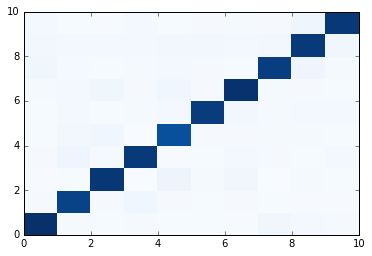

In [51]:
print ("Predictions")
labels = [chr(k) for k in range(ord("A"), ord("J")+1)]
n_val = 10000
X_val = valid_dataset[:n_val].reshape(-1, 
                    valid_dataset.shape[1]*train_dataset.shape[2])
y_val = valid_labels[:n_val]
print (X_val.shape, y_val.shape)
y_pred = model.predict(X_val)
print ("Confusion matrix: ")
plt.pcolor(confusion_matrix(y_pred, y_val), cmap="Blues")
print ("\n\t\t\t********Score:*******\n", 
       classification_report(y_pred, y_val, target_names=labels))